In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as plt
import seaborn as sns

%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
df_raw = pd.read_csv("../data/final_test.csv")
df_raw

,weight,age,height,size
0,62,28.0,172.72,XL
1,59,36.0,167.64,L
2,61,34.0,165.10,M
3,65,27.0,175.26,L
4,62,45.0,172.72,M
...,...,...,...,...
119729,63,42.0,175.26,M
119730,45,29.0,154.94,S
119731,61,31.0,172.72,M
119732,74,31.0,167.64,XL


In [3]:
df_raw.info()

<class 'pandas.DataFrame'>
RangeIndex: 119734 entries, 0 to 119733
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   weight  119734 non-null  int64  
 1   age     119477 non-null  float64
 2   height  119404 non-null  float64
 3   size    119734 non-null  str    
dtypes: float64(2), int64(1), str(1)
memory usage: 3.7 MB


In [4]:
df_raw.describe()

,weight,age,height
count,119734.000000,119477.000000,119404.000000
mean,61.756811,34.027311,165.805794
std,9.944863,8.149447,6.737651
min,22.000000,0.000000,137.160000
25%,55.000000,29.000000,160.020000
50%,61.000000,32.000000,165.100000
75%,67.000000,37.000000,170.180000
max,136.000000,117.000000,193.040000


In [5]:
df_raw["size"].value_counts()

size
M       29712
S       21924
XXXL    21359
XL      19119
L       17587
XXS      9964
XXL        69
Name: count, dtype: int64

<Axes: xlabel='size', ylabel='count'>

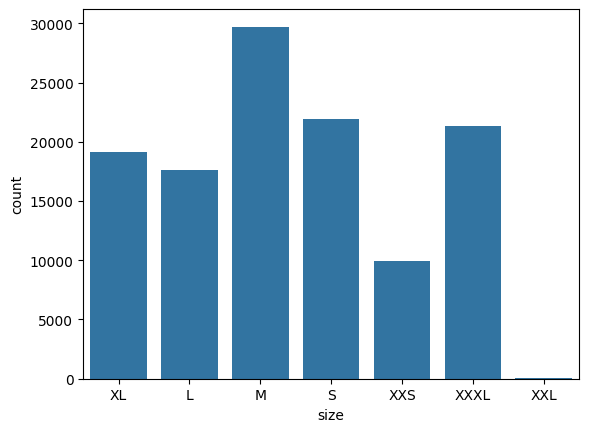

In [6]:
sns.countplot(x=df_raw["size"])

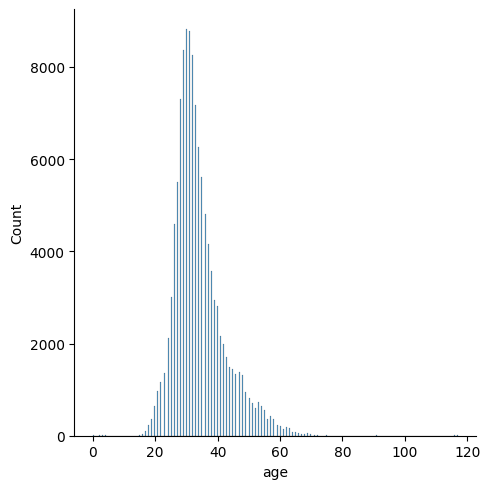

In [7]:
sns.displot(df_raw["age"])

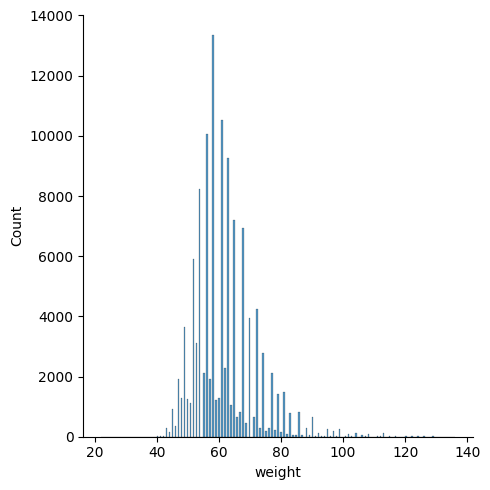

In [8]:
sns.displot(df_raw["weight"])

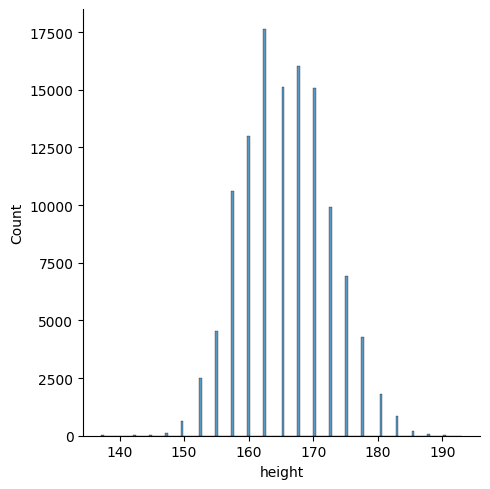

In [9]:
sns.displot(df_raw["height"])

In [10]:
dfs = []
sizes = []
for size_type in df_raw["size"].unique():
    sizes.append(size_type)
    ndf = df_raw[['age', 'height', 'weight']][df_raw['size'] == size_type]
    zscore = ((ndf - ndf.mean())/ndf.std())
    dfs.append(zscore)
    
for i in range (len(dfs)):
    dfs[i]['age'] = dfs[i]['age'][(dfs[i]['age']>-3) & (dfs[i]['age']<3)]
    dfs[i]['height'] = dfs[i]['height'][(dfs[i]['height']>-3) & (dfs[i]['height']<3)]
    dfs[i]['weight'] = dfs[i]['weight'][(dfs[i]['weight']>-3) & (dfs[i]['weight']<3)]
    
for i in range(len(sizes)):
    dfs[i]['size'] = sizes[i]
df_raw = pd.concat(dfs)
df_raw.head()

,age,height,weight,size
0,-0.833326,0.767729,-0.660757,XL
24,-0.713290,1.539527,1.556338,XL
25,-0.353183,-1.161765,-0.291241,XL
28,-0.473219,-1.933562,-1.399788,XL
34,0.126960,-0.775866,0.447791,XL


In [11]:
df_raw.isna().sum()

age       1678
height     547
weight    1069
size         0
dtype: int64

In [12]:
df_raw["age"] = df_raw["age"].fillna(df_raw['age'].median())
df_raw["height"] = df_raw["height"].fillna(df_raw['height'].median())
df_raw["weight"] = df_raw["weight"].fillna(df_raw['weight'].median())

In [13]:
df_raw['size'] = df_raw['size'].map({"XXS":1,
                                  "S":2,
                                  "M":3,
                                  "L":4,
                                  "XL":5,
                                  "XXL":6,
                                  "XXXL":7})

In [14]:
df_raw.isna().sum()

age       0
height    0
weight    0
size      0
dtype: int64

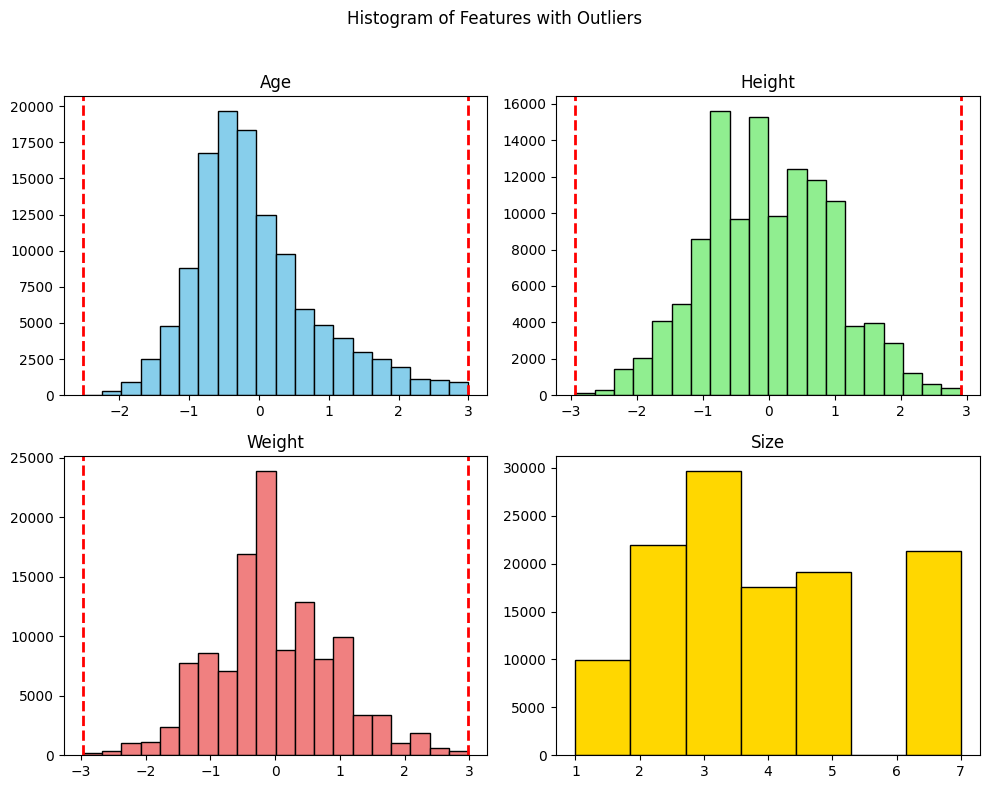

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Fungsi untuk mendeteksi outlier menggunakan metode IQR
def detect_outliers_iqr(data):
    Q1 = np.percentile(data, 25)  # Kuartil pertama
    Q3 = np.percentile(data, 75)  # Kuartil ketiga
    IQR = Q3 - Q1                 # Rentang antar kuartil
    lower_bound = Q1 - 1.5 * IQR   # Batas bawah
    upper_bound = Q3 + 1.5 * IQR   # Batas atas
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

# Mendeteksi outlier pada setiap fitur
outliers_age = detect_outliers_iqr(df_raw['age'])
outliers_height = detect_outliers_iqr(df_raw['height'])
outliers_weight = detect_outliers_iqr(df_raw['weight'])
outliers_size = detect_outliers_iqr(df_raw['size'])

# Plot histogram untuk setiap fitur
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Histogram of Features with Outliers')

# Age
axes[0, 0].hist(df_raw['age'], bins=20, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Age')
axes[0, 0].axvline(outliers_age.min(), color='red', linestyle='dashed', linewidth=2)
axes[0, 0].axvline(outliers_age.max(), color='red', linestyle='dashed', linewidth=2)

# Height
axes[0, 1].hist(df_raw['height'], bins=20, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Height')
axes[0, 1].axvline(outliers_height.min(), color='red', linestyle='dashed', linewidth=2)
axes[0, 1].axvline(outliers_height.max(), color='red', linestyle='dashed', linewidth=2)

# Weight
axes[1, 0].hist(df_raw['weight'], bins=20, color='lightcoral', edgecolor='black')
axes[1, 0].set_title('Weight')
axes[1, 0].axvline(outliers_weight.min(), color='red', linestyle='dashed', linewidth=2)
axes[1, 0].axvline(outliers_weight.max(), color='red', linestyle='dashed', linewidth=2)

# Size
axes[1, 1].hist(df_raw['size'], bins=7, color='gold', edgecolor='black')
axes[1, 1].set_title('Size')

# Menampilkan plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [16]:
df_raw

,age,height,weight,size
0,-0.833326,0.767729,-0.660757,5
24,-0.713290,1.539527,1.556338,5
25,-0.353183,-1.161765,-0.291241,5
28,-0.473219,-1.933562,-1.399788,5
34,0.126960,-0.775866,0.447791,5
...,...,...,...,...
112707,-1.236027,-1.489537,0.318135,6
114732,-0.633300,-0.052082,1.494100,6
114803,-0.432391,-0.052082,0.514129,6
114994,0.973972,-0.052082,-0.465841,6


In [17]:
df_raw["bmi"] = df_raw["height"]/df_raw["weight"]
df_raw["weight-squared"] = df_raw["weight"] * df_raw["weight"]

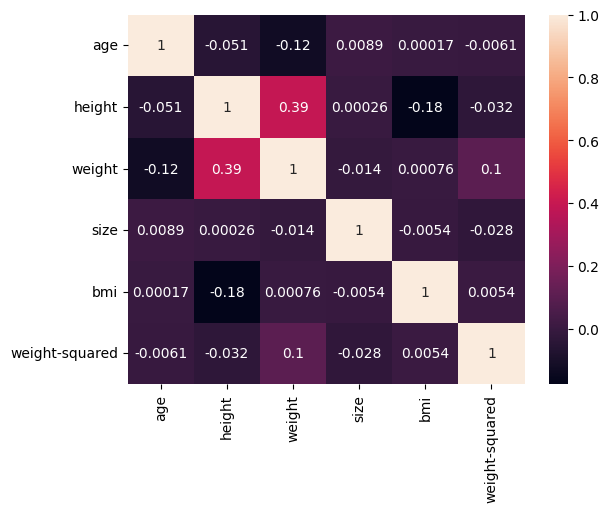

In [18]:
corr = sns.heatmap(df_raw.corr(), annot = True)

In [19]:
X = df_raw.drop("size", axis=1)
y = df_raw["size"]

In [20]:
X.head()

,age,height,weight,bmi,weight-squared
0,-0.833326,0.767729,-0.660757,-1.161894,0.436599
24,-0.713290,1.539527,1.556338,0.989198,2.422189
25,-0.353183,-1.161765,-0.291241,3.989017,0.084821
28,-0.473219,-1.933562,-1.399788,1.381325,1.959407
34,0.126960,-0.775866,0.447791,-1.732653,0.200517


In [21]:
y.head()

0     5
24    5
25    5
28    5
34    5
Name: size, dtype: int64

In [22]:
compression_opts = dict(method='zip', archive_name='out.csv')
df_raw.to_csv('out.csv', index=False)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [24]:
len(X_train), len(y_test)

(95787, 23947)

In [25]:
# Put models in a dictionary
models = {"Naive Bayes": GaussianNB()}
# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.

    Parameters:
    models: a dict of different Scikit Learn machine learning models
    X_train: training data (no labels)
    X_test: testing data (no labels)
    y_train: training labels
    y_test: test labels

    Returns:
    model_scores: a dictionary containing the scores of each model
    """
    # Set random seed
    np.random.seed(18)
    # Make a dictionary to keep model scores
    model_scores = {}

    # Loop through models
    for name, model in models.items():
        # Fit model to data
        model.fit(X_train, y_train)
        # Evaluate model and append its score to model scores
        model_scores[name] = model.score(X_test, y_test)
    
    return model_scores

In [26]:
model_scores = fit_and_score(models, X_train, X_test, y_train, y_test)
model_scores

{'Naive Bayes': 0.16590804693698585}

In [27]:
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

# Range untuk var_smoothing (gunakan logspace untuk membuat nilai smoothing dalam log scale)
param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

# Inisialisasi model Naive Bayes
gnb = GaussianNB()

# Grid Search dengan 5-fold cross validation
grid_search = GridSearchCV(gnb, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Menampilkan hasil hyperparameter terbaik
print(grid_search.best_params_)

{'var_smoothing': np.float64(0.43287612810830584)}


In [28]:
# Import libraries yang diperlukan
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Misalnya, clothessizeprediction adalah dataset yang sudah dimuat
# X berisi fitur (misalnya: usia, tinggi badan, berat badan, dsb)
# y berisi target prediksi ukuran baju

# Split data menjadi training set dan test set (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inisialisasi model Decision Tree dengan parameter yang lebih kompleks
clf = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=5)

# Melatih model dengn data training
clf.fit(X_train, y_train)

# Membuat prediksi pada data test
y_pred = clf.predict(X_test)

# Menampilkan hasil akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi Decision Tree: {accuracy:.2f}")

Akurasi Decision Tree: 0.71


In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Ensure y_train is zero-based (e.g., starts from 0)
y_train_adjusted = y_train - y_train.min()  # Adjust labels to start from 0
y_test_adjusted = y_test - y_test.min()

# Get the number of unique classes after adjustment
num_classes = len(np.unique(y_train_adjusted))

# One-hot encode y_train and y_test
y_train_one_hot = to_categorical(y_train_adjusted, num_classes)
y_test_one_hot = to_categorical(y_test_adjusted, num_classes)

# Ubah model dengan menambahkan Batch Normalization
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Step 7: Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 8: Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Step 9: Train the model
history = model.fit(X_train, y_train_one_hot, epochs=100, batch_size=64, validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr])

# Step 10: Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test_one_hot)
print(f"Test accuracy: {test_acc}")

# Step 11: Make predictions
predictions = model.predict(X_test)  # Corrected this line by closing the parenthesis
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test_one_hot, axis=1)

# Step 12: Accuracy score
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Prediction accuracy: {accuracy}")

ModuleNotFoundError: No module named 'tensorflow'